In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Add the parent directory to the system path 
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
#from scripts.economic_analysis import *

In [4]:
import wbdata
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import logging
from typing import Dict, Optional

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Define date range
start_date = datetime.datetime(1987, 5, 20)  # 1987-05-20
end_date = datetime.datetime(2022, 11, 14)   # 2022-11-14

# Define countries and indicators
countries = ['USA', 'SAU', 'RUS', 'IRN', 'CHN', 'ARE', 'IRQ', 'KWT', 'EUU']

indicators = {
    'NY.GDP.MKTP.CD': 'GDP Growth (%)',
    'FP.CPI.TOTL': 'Inflation Rate (%)',
    'SL.UEM.TOTL.ZS': 'Unemployment Rate (%)',
    'PA.NUS.FCRF': 'Exchange Rate (Local Currency per USD)',
    'EG.FEC.RNEW.ZS': 'Renewable Energy Consumption (%)',
    'CC.ENTX.ENV.ZS': 'Environmental Tax Revenue (% of GDP)',
    'BN.GSR.GNFS.CD': 'Net Trade (BoP, current US$)',
    'EG.ELC.NGAS.ZS': 'Natural Gas Electricity Production (%)'
}

def fetch_indicator_data(indicator_code: str, indicator_name: str) -> Optional[pd.DataFrame]:
    """
    Fetch data for a specific indicator from World Bank
    """
    try:
        # Fetch data
        data = wbdata.get_dataframe({indicator_code: indicator_name}, country=countries)
        
        # Process data
        if data is not None and not data.empty:
            data.reset_index(inplace=True)
            data['date'] = pd.to_datetime(data['date'])
            data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
            logger.info(f"Successfully fetched {indicator_name} data")
            return data
        else:
            logger.warning(f"No data returned for {indicator_name}")
            return None
            
    except Exception as e:
        logger.error(f"Error fetching {indicator_name}: {str(e)}")
        return None

def fetch_all_indicators() -> Dict[str, pd.DataFrame]:
    """
    Fetch all economic indicators
    """
    indicator_data = {}
    
    for code, name in indicators.items():
        data = fetch_indicator_data(code, name)
        if data is not None:
            indicator_data[name] = data
            
    return indicator_data

def merge_indicators(indicator_data: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    """
    Merge all indicator dataframes
    """
    try:
        # Start with the first dataframe
        merged_df = None
        
        for name, df in indicator_data.items():
            if merged_df is None:
                merged_df = df
                continue
                
            # Merge with existing dataframe
            merged_df = pd.merge(
                merged_df,
                df,
                on=['date', 'country'],
                how='outer'
            )
        
        if merged_df is not None:
            # Sort and clean the merged dataframe
            merged_df = merged_df.sort_values(['country', 'date'])
            merged_df = merged_df.fillna(method='ffill')
            logger.info("Successfully merged all indicators")
            return merged_df
        else:
            logger.warning("No data to merge")
            return pd.DataFrame()
            
    except Exception as e:
        logger.error(f"Error merging indicators: {str(e)}")
        return pd.DataFrame()

def analyze_correlations(merged_data: pd.DataFrame, oil_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze correlations between indicators and oil prices
    """
    try:
        # Merge with oil prices
        analysis_df = pd.merge(
            merged_data,
            oil_prices,
            on='date',
            how='inner'
        )
        
        # Calculate correlations for each country
        correlations = []
        for country in analysis_df['country'].unique():
            country_data = analysis_df[analysis_df['country'] == country]
            
            # Get correlations with oil price
            corr = country_data.corr()['Price'].drop(['Price'])
            
            corr_df = pd.DataFrame({
                'country': country,
                'indicator': corr.index,
                'correlation': corr.values
            })
            correlations.append(corr_df)
        
        return pd.concat(correlations, ignore_index=True)
        
    except Exception as e:
        logger.error(f"Error analyzing correlations: {str(e)}")
        return pd.DataFrame()

def plot_correlations(correlations: pd.DataFrame) -> None:
    """
    Create visualization for correlations
    """
    try:
        plt.figure(figsize=(15, 10))
        pivot_corr = correlations.pivot(
            index='indicator',
            #columns='country',
            values='correlation'
        )
        
        plt.imshow(pivot_corr, cmap='RdBu', aspect='auto')
        plt.colorbar(label='Correlation')
        
        plt.xticks(range(len(pivot_corr.columns)), pivot_corr.columns, rotation=45)
        plt.yticks(range(len(pivot_corr.index)), pivot_corr.index)
        
        plt.title('Correlation between Economic Indicators and Oil Prices by Country')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        logger.error(f"Error plotting correlations: {str(e)}")

# Main execution
if __name__ == "__main__":
    # Fetch all indicator data
    logger.info("Starting data collection...")
    indicator_data = fetch_all_indicators()
    
    # Merge all indicators
    merged_data = merge_indicators(indicator_data)
    
    # Display summary of collected data
    for name, df in indicator_data.items():
        print(f"\n{name} Data Summary:")
        print(df.head())
        print(f"Shape: {df.shape}")
        
    print("\nMerged Data Summary:")
    print(merged_data.head())
    print(f"Final Shape: {merged_data.shape}")
    
    # Note: To analyze correlations with oil prices, you would need to add:
    # oil_prices_df = pd.read_csv('your_oil_prices_file.csv')
    # oil_prices_df['date'] = pd.to_datetime(oil_prices_df['date'])
    # correlations = analyze_correlations(merged_data, oil_prices_df)
    # plot_correlations(correlations)

2024-11-09 17:35:00,255 - INFO - Starting data collection...
2024-11-09 17:35:00,255 - INFO - Successfully fetched GDP Growth (%) data
2024-11-09 17:35:00,270 - INFO - Successfully fetched Inflation Rate (%) data
2024-11-09 17:35:00,270 - INFO - Successfully fetched Unemployment Rate (%) data
2024-11-09 17:35:00,286 - INFO - Successfully fetched Exchange Rate (Local Currency per USD) data
2024-11-09 17:35:00,289 - INFO - Successfully fetched Renewable Energy Consumption (%) data
2024-11-09 17:35:00,289 - INFO - Successfully fetched Environmental Tax Revenue (% of GDP) data
2024-11-09 17:35:00,304 - INFO - Successfully fetched Net Trade (BoP, current US$) data
2024-11-09 17:35:00,304 - INFO - Successfully fetched Natural Gas Electricity Production (%) data
2024-11-09 17:35:00,320 - INFO - Successfully merged all indicators



GDP Growth (%) Data Summary:
                country       date  GDP Growth (%)
1  United Arab Emirates 2022-01-01    5.070640e+11
2  United Arab Emirates 2021-01-01    4.151788e+11
3  United Arab Emirates 2020-01-01    3.494730e+11
4  United Arab Emirates 2019-01-01    4.179897e+11
5  United Arab Emirates 2018-01-01    4.270494e+11
Shape: (315, 3)

Inflation Rate (%) Data Summary:
                country       date  Inflation Rate (%)
1  United Arab Emirates 2022-01-01          117.541088
2  United Arab Emirates 2021-01-01          112.127688
3  United Arab Emirates 2020-01-01          112.143231
4  United Arab Emirates 2019-01-01          114.524661
5  United Arab Emirates 2018-01-01          116.779773
Shape: (315, 3)

Unemployment Rate (%) Data Summary:
                country       date  Unemployment Rate (%)
1  United Arab Emirates 2022-01-01                  2.873
2  United Arab Emirates 2021-01-01                  3.105
3  United Arab Emirates 2020-01-01                  4.294

In [5]:
merged_data.head()

,country,date,GDP Growth (%),Inflation Rate (%),Unemployment Rate (%),Exchange Rate (Local Currency per USD),Renewable Energy Consumption (%),Environmental Tax Revenue (% of GDP),"Net Trade (BoP, current US$)",Natural Gas Electricity Production (%)
0,China,1988-01-01,3.123536e+11,33.187245,NaN,3.722100,NaN,NaN,-4.060000e+09,0.376552
9,China,1989-01-01,3.477681e+11,39.242469,NaN,3.765108,NaN,NaN,-4.927000e+09,0.634223
18,China,1990-01-01,3.608579e+11,40.440263,NaN,4.783208,33.9,NaN,1.066800e+10,0.446023
27,China,1991-01-01,3.833733e+11,41.878596,2.37,5.323392,33.1,NaN,1.160100e+10,0.358458
36,China,1992-01-01,4.269157e+11,44.539554,2.37,5.514592,32.8,NaN,4.998000e+09,0.327158


In [6]:
merged_data.tail()

,country,date,GDP Growth (%),Inflation Rate (%),Unemployment Rate (%),Exchange Rate (Local Currency per USD),Renewable Energy Consumption (%),Environmental Tax Revenue (% of GDP),"Net Trade (BoP, current US$)",Natural Gas Electricity Production (%)
278,United States,2018-01-01,2.065652e+13,115.157303,3.896,1.0,9.9,0.713,-5.786000e+11,31.942161
287,United States,2019-01-01,2.152140e+13,117.244195,3.669,1.0,10.2,0.713,-5.593940e+11,31.942161
296,United States,2020-01-01,2.132295e+13,118.690502,8.055,1.0,11.0,0.713,-6.536940e+11,31.942161
305,United States,2021-01-01,2.359403e+13,124.266414,5.349,1.0,10.9,0.713,-8.480720e+11,31.942161
314,United States,2022-01-01,2.574411e+13,134.211206,3.650,1.0,10.9,0.713,-9.447700e+11,31.942161


In [7]:
#merged_data = merged_data.drop('country', axis=1)


In [8]:
merged_data.head()

,country,date,GDP Growth (%),Inflation Rate (%),Unemployment Rate (%),Exchange Rate (Local Currency per USD),Renewable Energy Consumption (%),Environmental Tax Revenue (% of GDP),"Net Trade (BoP, current US$)",Natural Gas Electricity Production (%)
0,China,1988-01-01,3.123536e+11,33.187245,NaN,3.722100,NaN,NaN,-4.060000e+09,0.376552
9,China,1989-01-01,3.477681e+11,39.242469,NaN,3.765108,NaN,NaN,-4.927000e+09,0.634223
18,China,1990-01-01,3.608579e+11,40.440263,NaN,4.783208,33.9,NaN,1.066800e+10,0.446023
27,China,1991-01-01,3.833733e+11,41.878596,2.37,5.323392,33.1,NaN,1.160100e+10,0.358458
36,China,1992-01-01,4.269157e+11,44.539554,2.37,5.514592,32.8,NaN,4.998000e+09,0.327158


In [9]:
merged_data.info()

<class 'wbdata.client.DataFrame'>
Index: 315 entries, 0 to 314
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   country                                 315 non-null    object        
 1   date                                    315 non-null    datetime64[ns]
 2   GDP Growth (%)                          315 non-null    float64       
 3   Inflation Rate (%)                      315 non-null    float64       
 4   Unemployment Rate (%)                   312 non-null    float64       
 5   Exchange Rate (Local Currency per USD)  315 non-null    float64       
 6   Renewable Energy Consumption (%)        313 non-null    float64       
 7   Environmental Tax Revenue (% of GDP)    291 non-null    float64       
 8   Net Trade (BoP, current US$)            315 non-null    float64       
 9   Natural Gas Electricity Production (%)  315 non-null    float64

In [10]:
#merged_data.fillna(merged_data.median(), inplace=True)


In [11]:
# # Note: To analyze correlations with oil prices, you would need to add:
# oil_prices_df = pd.read_csv('../data/Copy of BrentOilPrices.csv')
# oil_prices_df['date'] = pd.to_datetime(oil_prices_df['Date'])
# correlations = analyze_correlations(merged_data, oil_prices_df)
# plot_correlations(correlations)

In [12]:
merged_data.head()

,country,date,GDP Growth (%),Inflation Rate (%),Unemployment Rate (%),Exchange Rate (Local Currency per USD),Renewable Energy Consumption (%),Environmental Tax Revenue (% of GDP),"Net Trade (BoP, current US$)",Natural Gas Electricity Production (%)
0,China,1988-01-01,3.123536e+11,33.187245,NaN,3.722100,NaN,NaN,-4.060000e+09,0.376552
9,China,1989-01-01,3.477681e+11,39.242469,NaN,3.765108,NaN,NaN,-4.927000e+09,0.634223
18,China,1990-01-01,3.608579e+11,40.440263,NaN,4.783208,33.9,NaN,1.066800e+10,0.446023
27,China,1991-01-01,3.833733e+11,41.878596,2.37,5.323392,33.1,NaN,1.160100e+10,0.358458
36,China,1992-01-01,4.269157e+11,44.539554,2.37,5.514592,32.8,NaN,4.998000e+09,0.327158


In [13]:
merged_data.isnull().sum()

country                                    0
date                                       0
GDP Growth (%)                             0
Inflation Rate (%)                         0
Unemployment Rate (%)                      3
Exchange Rate (Local Currency per USD)     0
Renewable Energy Consumption (%)           2
Environmental Tax Revenue (% of GDP)      24
Net Trade (BoP, current US$)               0
Natural Gas Electricity Production (%)     0
dtype: int64

In [14]:
# Note: To analyze correlations with oil prices, you would need to add:
oil_prices_df = pd.read_csv('../data/Copy of BrentOilPrices.csv')
oil_prices_df['date'] = pd.to_datetime(oil_prices_df['Date'])
correlations = analyze_correlations(merged_data, oil_prices_df)
plot_correlations(correlations)

2024-11-09 17:35:00,806 - ERROR - Error analyzing correlations: could not convert string to float: 'China'
2024-11-09 17:35:00,806 - ERROR - Error plotting correlations: DataFrame.pivot() missing 1 required keyword-only argument: 'columns'


<Figure size 1500x1000 with 0 Axes>

In [15]:
merged_data.rename(columns={'date': 'Date'}, inplace=True)

In [16]:
# to datetime
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
oil_prices_df['Date'] = pd.to_datetime(oil_prices_df['Date'])

#extract year
merged_data['year'] = merged_data['Date'].dt.year
oil_prices_df['year'] = oil_prices_df['Date'].dt.year 

In [17]:
# Merging on Date column
merged_df = pd.merge(merged_data, oil_prices_df, on='year', how='left')  # 'how' can be 'inner', 'outer', 'left', or 'right'

print(merged_df)

             country     Date_x  GDP Growth (%)  Inflation Rate (%)  \
0              China 1988-01-01    3.123536e+11           33.187245   
1              China 1988-01-01    3.123536e+11           33.187245   
2              China 1988-01-01    3.123536e+11           33.187245   
3              China 1988-01-01    3.123536e+11           33.187245   
4              China 1988-01-01    3.123536e+11           33.187245   
...              ...        ...             ...                 ...   
79654  United States 2022-01-01    2.574411e+13          134.211206   
79655  United States 2022-01-01    2.574411e+13          134.211206   
79656  United States 2022-01-01    2.574411e+13          134.211206   
79657  United States 2022-01-01    2.574411e+13          134.211206   
79658  United States 2022-01-01    2.574411e+13          134.211206   

       Unemployment Rate (%)  Exchange Rate (Local Currency per USD)  \
0                        NaN                                  3.7221   
1  

In [18]:
merged_df.head()

,country,Date_x,GDP Growth (%),Inflation Rate (%),Unemployment Rate (%),Exchange Rate (Local Currency per USD),Renewable Energy Consumption (%),Environmental Tax Revenue (% of GDP),"Net Trade (BoP, current US$)",Natural Gas Electricity Production (%),year,Date_y,Price,date
0,China,1988-01-01,3.123536e+11,33.187245,NaN,3.7221,NaN,NaN,-4.060000e+09,0.376552,1988,1988-01-04,17.95,1988-01-04
1,China,1988-01-01,3.123536e+11,33.187245,NaN,3.7221,NaN,NaN,-4.060000e+09,0.376552,1988,1988-01-05,17.08,1988-01-05
2,China,1988-01-01,3.123536e+11,33.187245,NaN,3.7221,NaN,NaN,-4.060000e+09,0.376552,1988,1988-01-06,17.90,1988-01-06
3,China,1988-01-01,3.123536e+11,33.187245,NaN,3.7221,NaN,NaN,-4.060000e+09,0.376552,1988,1988-01-08,16.88,1988-01-08
4,China,1988-01-01,3.123536e+11,33.187245,NaN,3.7221,NaN,NaN,-4.060000e+09,0.376552,1988,1988-01-11,16.65,1988-01-11


In [19]:
merged_df.tail()

,country,Date_x,GDP Growth (%),Inflation Rate (%),Unemployment Rate (%),Exchange Rate (Local Currency per USD),Renewable Energy Consumption (%),Environmental Tax Revenue (% of GDP),"Net Trade (BoP, current US$)",Natural Gas Electricity Production (%),year,Date_y,Price,date
79654,United States,2022-01-01,2.574411e+13,134.211206,3.65,1.0,10.9,0.713,-9.447700e+11,31.942161,2022,2022-11-08,96.85,2022-11-08
79655,United States,2022-01-01,2.574411e+13,134.211206,3.65,1.0,10.9,0.713,-9.447700e+11,31.942161,2022,2022-11-09,93.05,2022-11-09
79656,United States,2022-01-01,2.574411e+13,134.211206,3.65,1.0,10.9,0.713,-9.447700e+11,31.942161,2022,2022-11-10,94.25,2022-11-10
79657,United States,2022-01-01,2.574411e+13,134.211206,3.65,1.0,10.9,0.713,-9.447700e+11,31.942161,2022,2022-11-11,96.37,2022-11-11
79658,United States,2022-01-01,2.574411e+13,134.211206,3.65,1.0,10.9,0.713,-9.447700e+11,31.942161,2022,2022-11-14,93.59,2022-11-14


In [20]:
merged_df.shape

(79659, 14)

In [21]:
def merge_with_oil_prices(merged_data: pd.DataFrame, oil_prices_df: pd.DataFrame) -> pd.DataFrame:
    """
    Merge economic indicators with oil prices, keeping only the Price column
    """
    try:
        # Ensure date columns are datetime
        oil_prices_df['Date'] = pd.to_datetime(oil_prices_df['Date'])
        
        # Create a year column for both dataframes
        merged_data['year'] = merged_data['Date'].dt.year
        oil_prices_df['year'] = oil_prices_df['Date'].dt.year
        
        # Keep only the Price column for merging
        oil_prices_yearly = oil_prices_df[['year', 'Price']].drop_duplicates()
        
        # Merge on year
        final_df = pd.merge(
            merged_data,
            oil_prices_yearly,
            on='year',
            how='inner'
        )
        
        return final_df
        
    except Exception as e:
        print(f"Error merging with oil prices: {str(e)}")
        return pd.DataFrame()

In [22]:
final_df = merge_with_oil_prices(merged_data, oil_prices_df)

In [23]:
final_df.head()

,country,Date,GDP Growth (%),Inflation Rate (%),Unemployment Rate (%),Exchange Rate (Local Currency per USD),Renewable Energy Consumption (%),Environmental Tax Revenue (% of GDP),"Net Trade (BoP, current US$)",Natural Gas Electricity Production (%),year,Price
0,China,1988-01-01,3.123536e+11,33.187245,NaN,3.7221,NaN,NaN,-4.060000e+09,0.376552,1988,17.95
1,China,1988-01-01,3.123536e+11,33.187245,NaN,3.7221,NaN,NaN,-4.060000e+09,0.376552,1988,17.08
2,China,1988-01-01,3.123536e+11,33.187245,NaN,3.7221,NaN,NaN,-4.060000e+09,0.376552,1988,17.90
3,China,1988-01-01,3.123536e+11,33.187245,NaN,3.7221,NaN,NaN,-4.060000e+09,0.376552,1988,16.88
4,China,1988-01-01,3.123536e+11,33.187245,NaN,3.7221,NaN,NaN,-4.060000e+09,0.376552,1988,16.65


In [24]:
def create_visualizations(final_df: pd.DataFrame, oil_prices_df: pd.DataFrame):
    """
    Create various visualizations for the analysis
    """
    # 1. Time Series Plot of Oil Prices and Major Indicators
    plt.figure(figsize=(15, 8))
    for country in final_df['country'].unique():
        country_data = final_df[final_df['country'] == country]
        plt.plot(country_data['Date'], country_data['GDP Growth (%)'], label=f'{country} GDP Growth')
    
    plt.plot(oil_prices_df['Date'], oil_prices_df['Price'], 'r--', label='Oil Price', alpha=0.7)
    plt.title('GDP Growth and Oil Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 2. Oil Price Distribution by Year
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=oil_prices_df, x=oil_prices_df['Date'].dt.year, y='Price')
    plt.title('Oil Price Distribution by Year')
    plt.xticks(rotation=45)
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.tight_layout()
    plt.show()

    # 3. Correlation Heatmap
    plt.figure(figsize=(12, 8))
    numeric_cols = final_df.select_dtypes(include=[np.number]).columns
    # Exclude 'year' column for correlation
    numeric_cols = [col for col in numeric_cols if col != 'year']
    correlation_matrix = final_df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap of Economic Indicators and Oil Prices')
    plt.tight_layout()
    plt.show()

    # 4. Scatter Plots Matrix for Key Indicators
    key_indicators = ['GDP Growth (%)', 'Inflation Rate (%)', 'Price']
    sns.pairplot(final_df[key_indicators + ['country']], hue='country')
    plt.suptitle('Scatter Plot Matrix of Key Indicators', y=1.02)
    plt.show()

def perform_correlation_analysis(final_df: pd.DataFrame) -> pd.DataFrame:
    """
    Perform detailed correlation analysis between oil prices and economic indicators
    """
    correlation_results = []
    
    # Analyze for each country
    for country in final_df['country'].unique():
        country_data = final_df[final_df['country'] == country]
        
        # Get numeric columns excluding oil price statistics and year column
        indicator_cols = [col for col in country_data.select_dtypes(include=[np.number]).columns 
                         if not col.startswith('oil_price_') and col != 'year']
        
        for indicator in indicator_cols:
            # Calculate correlation
            correlation, p_value = stats.pearsonr(
                country_data[indicator].fillna(method='ffill'), 
                country_data['Price']
            )
            
            # Calculate rolling correlation (2-year window)
            rolling_corr = country_data[indicator].rolling(window=24).corr(country_data['oil_price_av'])
            
            correlation_results.append({
                'country': country,
                'indicator': indicator,
                'correlation': correlation,
                'abs_correlation': abs(correlation),
                'p_value': p_value,
                'significant': p_value < 0.05,
                'correlation_strength': 'Strong' if abs(correlation) > 0.7 else 'Moderate' if abs(correlation) > 0.3 else 'Weak',
                'avg_rolling_correlation': rolling_corr.mean()
            })
    
    return pd.DataFrame(correlation_results)

def plot_correlation_analysis(correlation_results: pd.DataFrame):
    """
    Visualize correlation analysis results
    """
    # 1. Bar plot of correlations by country and indicator
    plt.figure(figsize=(15, 8))
    pivot_data = correlation_results.pivot(index='indicator', columns='country', values='correlation')
    pivot_data.plot(kind='bar')
    plt.title('Correlation with Oil Prices by Country and Indicator')
    plt.xlabel('Economic Indicator')
    plt.ylabel('Correlation Coefficient')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 2. Significant correlations highlight
    plt.figure(figsize=(12, 6))
    significant_corr = correlation_results[correlation_results['significant']]
    sns.scatterplot(
        data=significant_corr, 
        x='correlation', 
        y='indicator', 
        hue='country', 
        size='avg_rolling_correlation',
        sizes=(50, 200)
    )
    plt.title('Significant Correlations with Oil Prices')
    plt.xlabel('Correlation Coefficient')
    plt.tight_layout()
    plt.show()


In [25]:
 # Merge with oil prices
final_df = merge_with_oil_prices(merged_data, oil_prices_df)

In [26]:
final_df.head()

,country,Date,GDP Growth (%),Inflation Rate (%),Unemployment Rate (%),Exchange Rate (Local Currency per USD),Renewable Energy Consumption (%),Environmental Tax Revenue (% of GDP),"Net Trade (BoP, current US$)",Natural Gas Electricity Production (%),year,Price
0,China,1988-01-01,3.123536e+11,33.187245,NaN,3.7221,NaN,NaN,-4.060000e+09,0.376552,1988,17.95
1,China,1988-01-01,3.123536e+11,33.187245,NaN,3.7221,NaN,NaN,-4.060000e+09,0.376552,1988,17.08
2,China,1988-01-01,3.123536e+11,33.187245,NaN,3.7221,NaN,NaN,-4.060000e+09,0.376552,1988,17.90
3,China,1988-01-01,3.123536e+11,33.187245,NaN,3.7221,NaN,NaN,-4.060000e+09,0.376552,1988,16.88
4,China,1988-01-01,3.123536e+11,33.187245,NaN,3.7221,NaN,NaN,-4.060000e+09,0.376552,1988,16.65


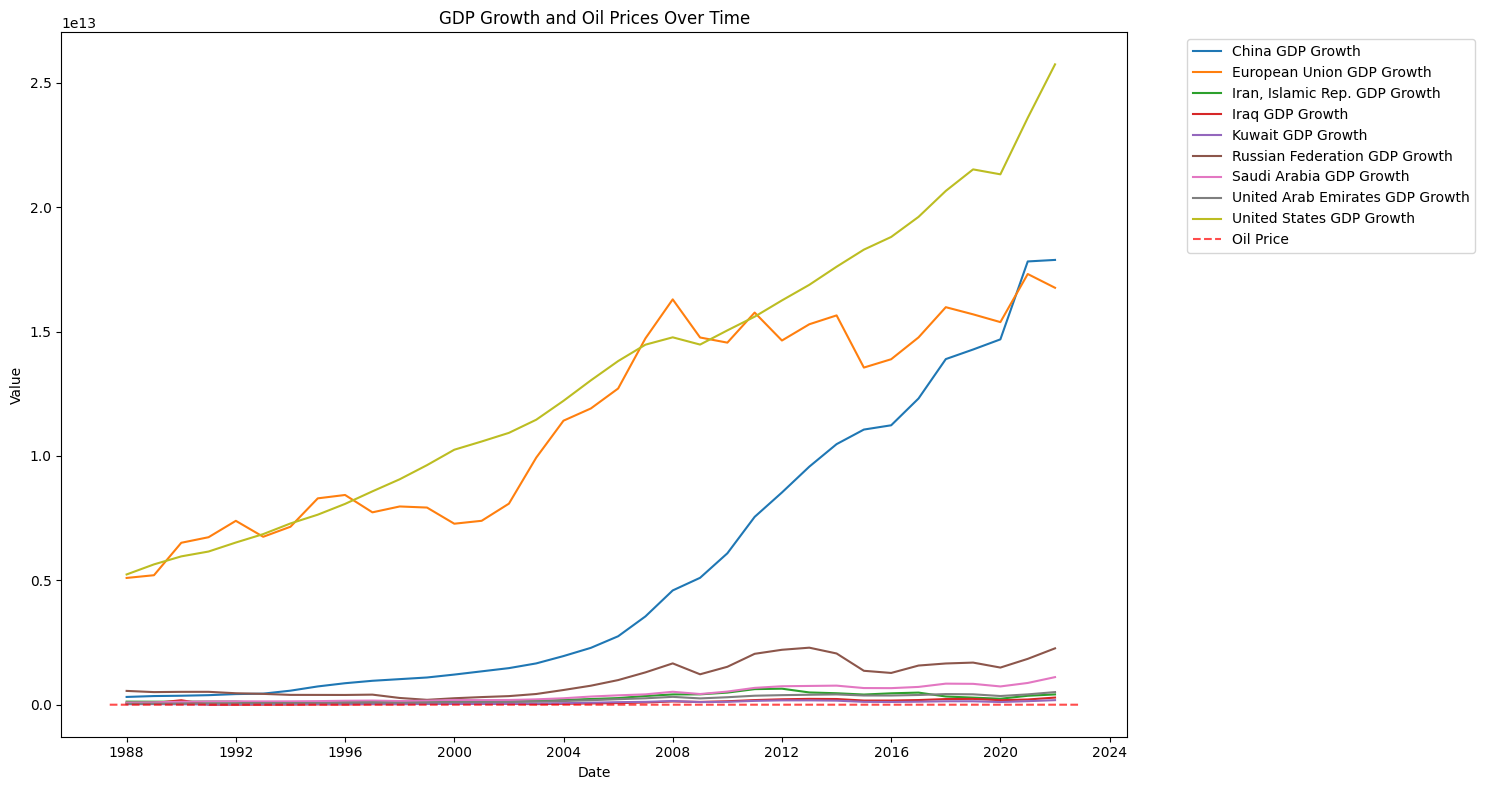

2024-11-09 17:35:01,574 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-09 17:35:01,599 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


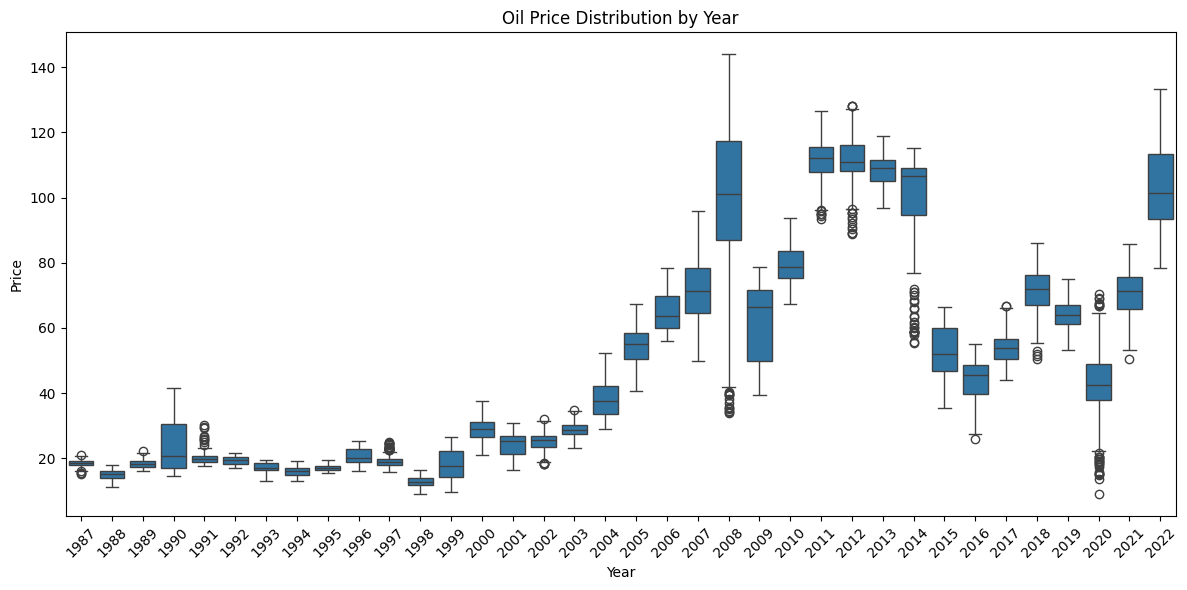

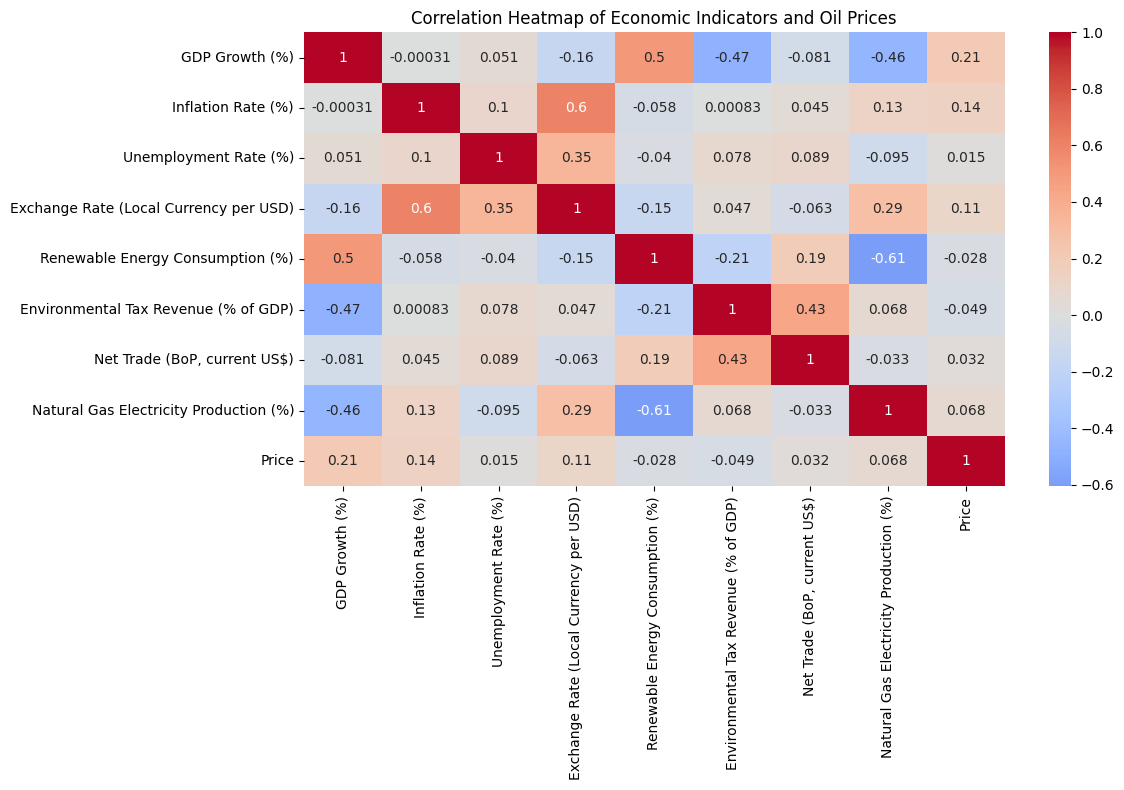

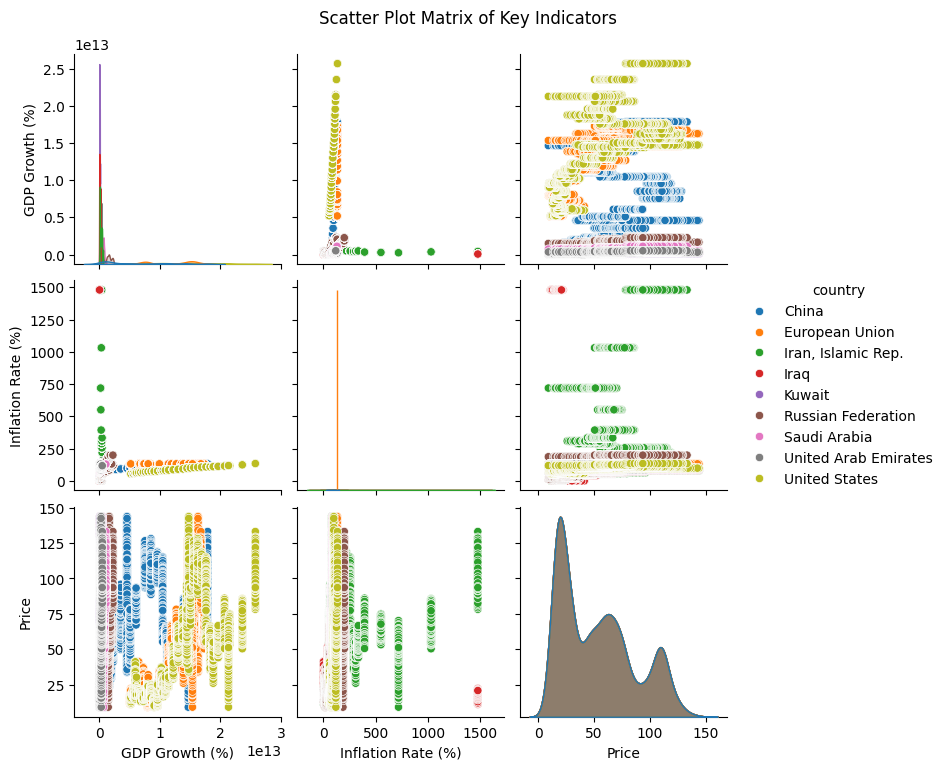

In [27]:
# Create visualizations
create_visualizations(final_df, oil_prices_df)

In [28]:
# Perform correlation analysis
correlation_results = perform_correlation_analysis(final_df)

NameError: name 'stats' is not defined

<Figure size 1500x800 with 0 Axes>

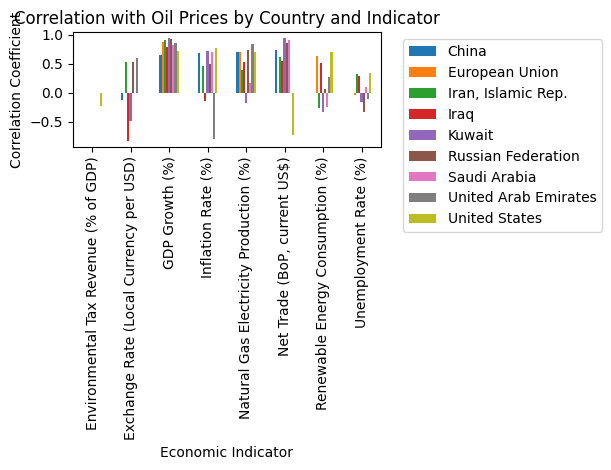

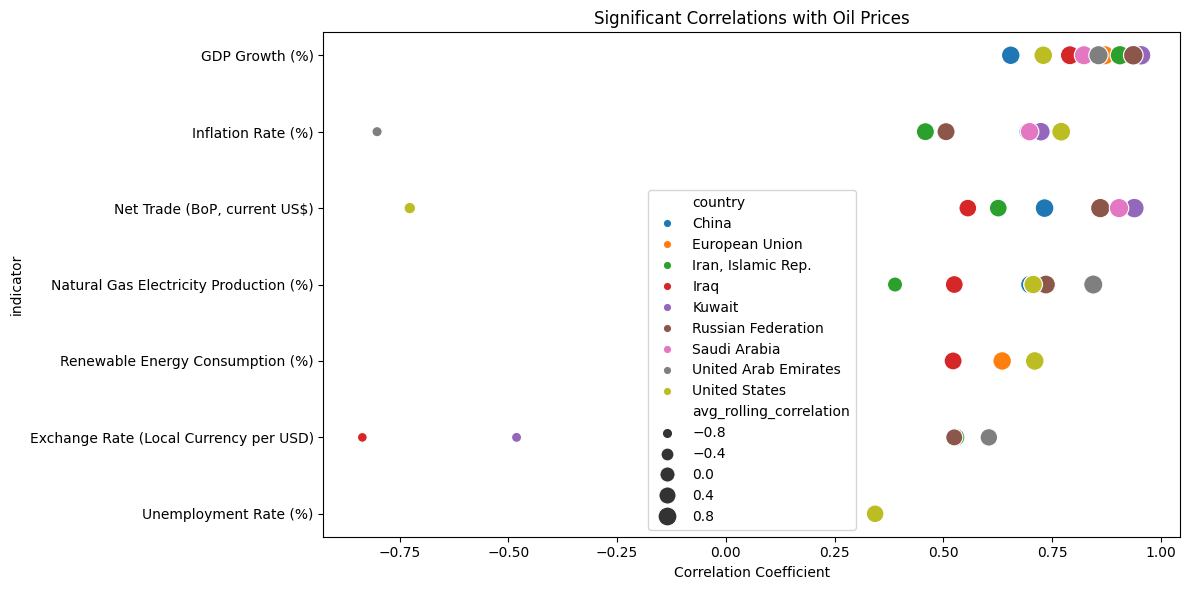

In [ ]:
# Plot correlation analysis results
plot_correlation_analysis(correlation_results)

In [ ]:
# Print detailed correlation results
print("\nDetailed Correlation Analysis Results:")
print(correlation_results.sort_values('abs_correlation', ascending=False)
          .to_string(index=False))


Detailed Correlation Analysis Results:
             country                              indicator  correlation  abs_correlation      p_value  significant correlation_strength  avg_rolling_correlation
              Kuwait                         GDP Growth (%)     0.954324         0.954324 6.994777e-19         True               Strong                 0.964859
              Kuwait           Net Trade (BoP, current US$)     0.938879         0.938879 7.618429e-17         True               Strong                 0.960250
  Russian Federation                         GDP Growth (%)     0.936492         0.936492 1.407817e-16         True               Strong                 0.949706
  Iran, Islamic Rep.                         GDP Growth (%)     0.905650         0.905650 7.650913e-14         True               Strong                 0.914918
        Saudi Arabia           Net Trade (BoP, current US$)     0.903681         0.903681 1.059773e-13         True               Strong              

In [ ]:
# Print summary of strongest correlations
print("\nStrongest Correlations with Oil Prices:")
strong_correlations = correlation_results[
     correlation_results['correlation_strength'] == 'Strong'
].sort_values('abs_correlation', ascending=False)
print(strong_correlations.to_string(index=False))


Strongest Correlations with Oil Prices:
             country                              indicator  correlation  abs_correlation      p_value  significant correlation_strength  avg_rolling_correlation
              Kuwait                         GDP Growth (%)     0.954324         0.954324 6.994777e-19         True               Strong                 0.964859
              Kuwait           Net Trade (BoP, current US$)     0.938879         0.938879 7.618429e-17         True               Strong                 0.960250
  Russian Federation                         GDP Growth (%)     0.936492         0.936492 1.407817e-16         True               Strong                 0.949706
  Iran, Islamic Rep.                         GDP Growth (%)     0.905650         0.905650 7.650913e-14         True               Strong                 0.914918
        Saudi Arabia           Net Trade (BoP, current US$)     0.903681         0.903681 1.059773e-13         True               Strong             

Correlation between Brent Oil Prices and GDP Growth: 0.24


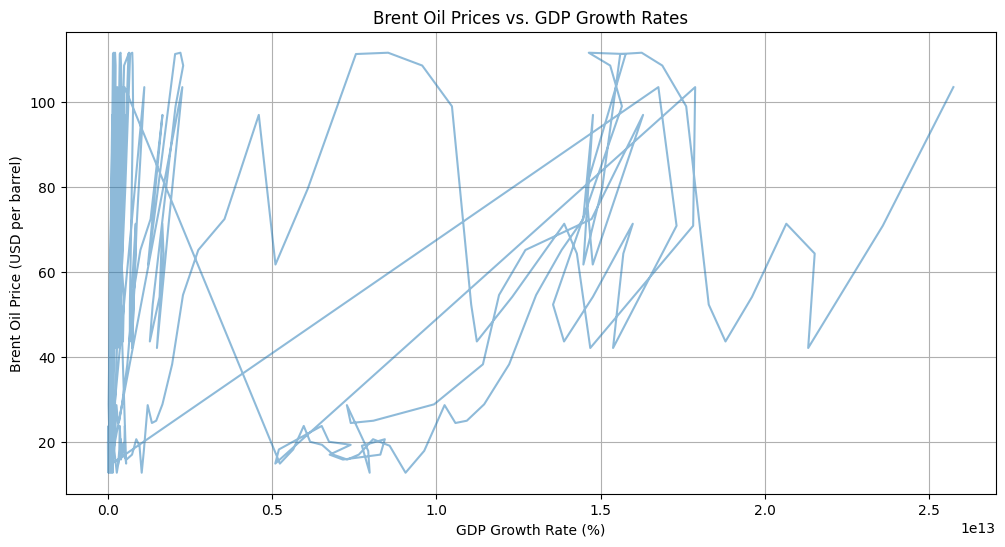

In [ ]:
# Step 15: Analyze correlation
correlation = final_df['oil_price_max'].corr(final_df['GDP Growth (%)'])
print(f"Correlation between Brent Oil Prices and GDP Growth: {correlation:.2f}")

# Step 16: Visualize the relationship
plt.figure(figsize=(12, 6))
plt.plot(final_df['GDP Growth (%)'], final_df['Price'], alpha=0.5)
plt.title('Brent Oil Prices vs. GDP Growth Rates')
plt.xlabel('GDP Growth Rate (%)')
plt.ylabel('Brent Oil Price (USD per barrel)')
plt.grid()
plt.show()

Correlation between Brent Oil Prices and Inflation Rate: 0.14


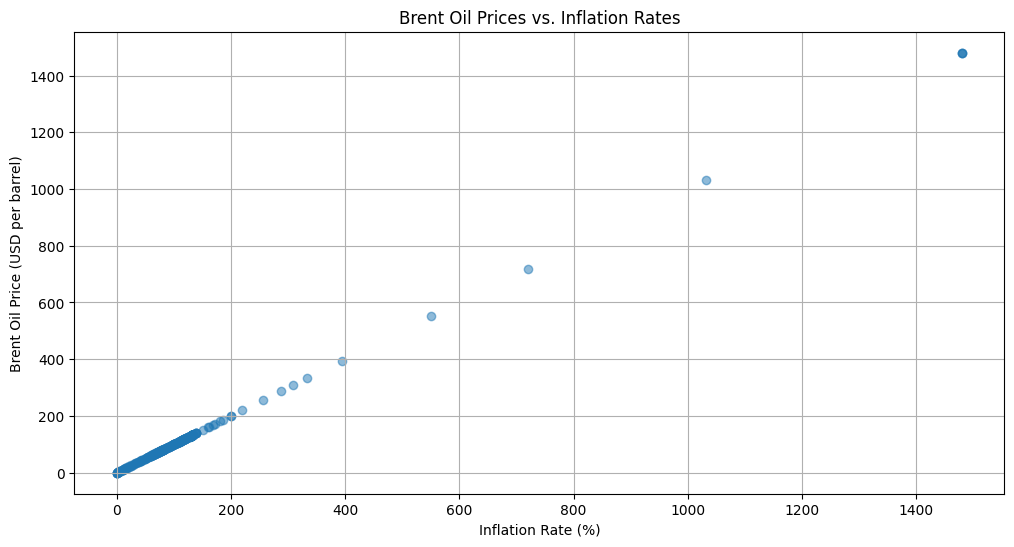

In [ ]:
# Step 15: Analyze correlation
correlation = final_df['oil_price_max'].corr(final_df['Inflation Rate (%)'])
print(f"Correlation between Brent Oil Prices and Inflation Rate: {correlation:.2f}")

# Optionally, visualize the relationship
plt.figure(figsize=(12, 6))
plt.scatter(final_df['Inflation Rate (%)'], final_df['Inflation Rate (%)'], alpha=0.5)
plt.title('Brent Oil Prices vs. Inflation Rates')
plt.xlabel('Inflation Rate (%)')
plt.ylabel('Brent Oil Price (USD per barrel)')
plt.grid()
plt.show()

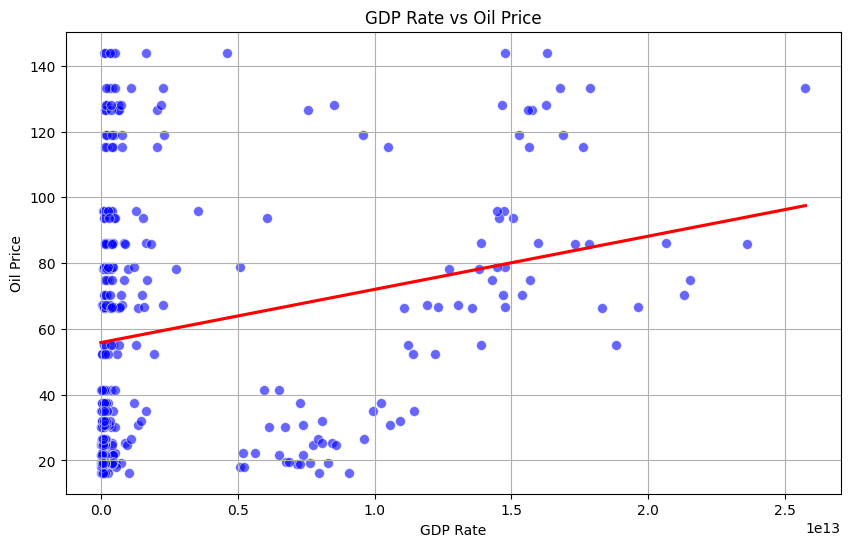

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample code to generate the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GDP Growth (%)', y='oil_price_max', data=final_df, color='blue', s=50, alpha=0.6)
sns.regplot(x='GDP Growth (%)', y='oil_price_max', data=final_df, scatter=False, color='red', ci=None)  # Adds a regression line

# Adding titles and labels
plt.title('GDP Rate vs Oil Price')
plt.xlabel('GDP Rate')
plt.ylabel('Oil Price')
plt.grid(True)
plt.show()
